In [9]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load Superstore dataset 
df = pd.read_csv('SampleSuperstoreClean.csv')

df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Profit Margin'] = df['Profit'] / df['Sales']

Furniture Performance Test
H₀: Profit margin distributions are equal for Furniture and other categories.
H₁: Profit margin distributions differ between Furniture and other categories.
Normality (D'Agostino K², Furniture, n=2121): Failed (p=0.0000)
Normality (D'Agostino K², Others, n=7873): Failed (p=0.0000)
Normality test failed for at least one group.
Homogeneity of Variances (Levene): Failed
Mann-Whitney U: Statistic=5331617.00, p=0.0000
Conclusion: Reject H₀; Furniture profit margin differs, supporting need to fix Furniture category.

Median Profit Margin by Group:
Furniture: 0.1111
Others: 0.2900


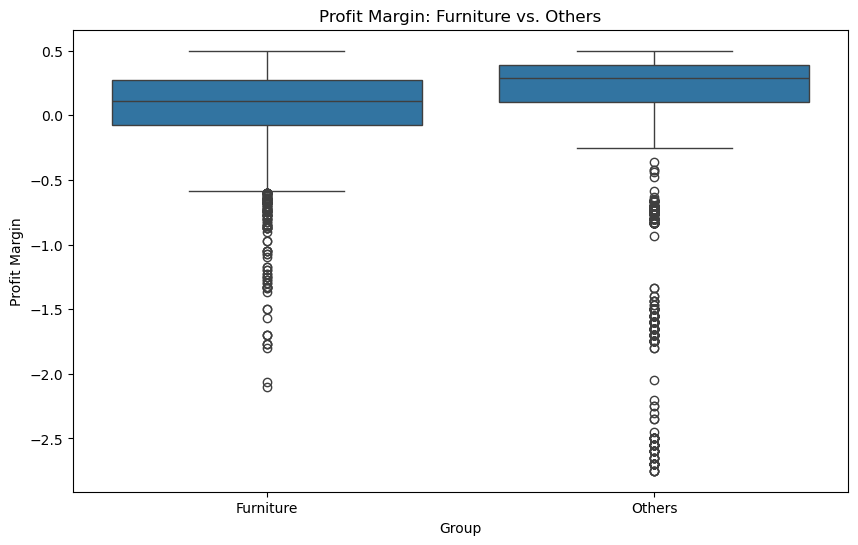

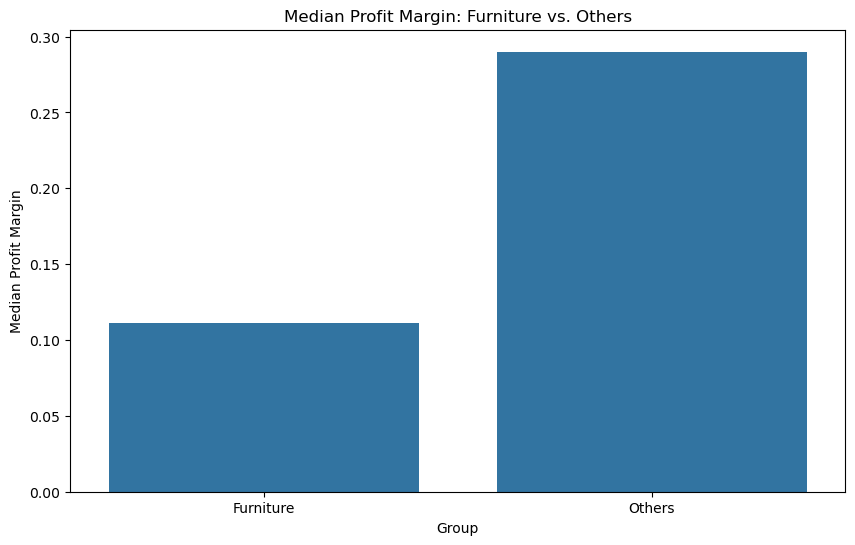

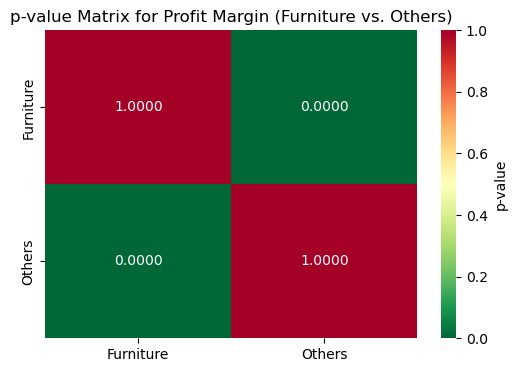

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(42)

# Calculate profit margin, handle zero sales
df['Profit Margin'] = df.apply(lambda x: x['Profit'] / x['Sales'] if x['Sales'] != 0 else np.nan, axis=1)
alpha = 0.05

def check_assumptions(data_groups, group_names):
    normality = True
    normality_results = []
    
    # Check normality for each group
    for group, name in zip(data_groups, group_names):
        n = len(group)
        if n < 3:
            print(f"Normality ({name}, n={n}): Skipped (sample size < 3)")
            normality_results.append(False)
            continue
        if n < 50:  # Shapiro-Wilk for smaller samples
            p_value = stats.shapiro(group)[1]
            test_name = "Shapiro-Wilk"
        else:  # D'Agostino K² for larger samples
            p_value = stats.normaltest(group)[1]
            test_name = "D'Agostino K²"
        normality_results.append(p_value > alpha)
        print(f"Normality ({test_name}, {name}, n={n}): {'Passed' if p_value > alpha else 'Failed'} (p={p_value:.4f})")
    
    # Aggregate normality
    normality = all(normality_results)
    if not normality:
        print("Normality test failed for at least one group.")
    
    # Check homogeneity of variances
    homogeneity = stats.levene(*data_groups, center='median')[1] > alpha if len(data_groups) > 1 else True
    print(f"Homogeneity of Variances (Levene): {'Passed' if homogeneity else 'Failed'}")
    
    # Force Mann-Whitney U if any group has n < 3
    if any(len(group) < 3 for group in data_groups):
        print("At least one group has insufficient data (<3); defaulting to Mann-Whitney U.")
        return False
    
    return normality and homogeneity

def summarize_medians(df, metric, group_col, groups):
    """Summarize median profit margins for groups and return medians."""
    medians = {group: df[df[group_col] == group][metric].median() for group in groups}
    print(f"\nMedian {metric} by Group:")
    for group, median in medians.items():
        print(f"{group}: {median:.4f}")
    return pd.Series(medians)

def plot_median_bar(medians, metric, title, filename):
    """Plot bar chart for median rankings."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x=medians.index, y=medians.values)
    plt.title(title)
    plt.xlabel('Group')
    plt.ylabel(f'Median {metric}')
    plt.savefig(filename)
    plt.show()

def plot_pvalue_matrix(p_value, group_names, metric, filename):
    """Plot a 2x2 matrix for the single p-value from t-test or Mann-Whitney U."""
    p_matrix = np.ones((2, 2))  # Initialize 2x2 matrix with ones
    p_matrix[0, 1] = p_value    # Set p-value for Furniture vs. Others
    p_matrix[1, 0] = p_value    # Symmetric for visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(p_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r', 
                vmin=0, vmax=1, cbar_kws={'label': 'p-value'}, 
                xticklabels=group_names, yticklabels=group_names)
    plt.title(f'p-value Matrix for {metric} (Furniture vs. Others)')
    plt.savefig(filename)
    plt.show()

# Furniture Performance Analysis
print("Furniture Performance Test")
print("H₀: Profit margin distributions are equal for Furniture and other categories.")
print("H₁: Profit margin distributions differ between Furniture and other categories.")

# Create Group column before analysis
df['Group'] = df['Category'].apply(lambda x: 'Furniture' if x == 'Furniture' else 'Others')

furniture_margin = df[df['Category'] == 'Furniture']['Profit Margin'].dropna()
other_margin = df[df['Category'] != 'Furniture']['Profit Margin'].dropna()
group_names = ['Furniture', 'Others']
if check_assumptions([furniture_margin, other_margin], group_names):
    t_stat, p_value = stats.ttest_ind(furniture_margin, other_margin)
    test_name = "T-test"
else:
    t_stat, p_value = stats.mannwhitneyu(furniture_margin, other_margin, alternative='two-sided')
    test_name = "Mann-Whitney U"
print(f"{test_name}: Statistic={t_stat:.2f}, p={p_value:.4f}")
print("Conclusion:", "Reject H₀; Furniture profit margin differs, supporting need to fix Furniture category." if p_value < alpha else "Fail to reject H₀; insufficient evidence to prioritize Furniture fixes.")
medians = summarize_medians(df, 'Profit Margin', 'Group', group_names)

# Visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Profit Margin', data=df)
plt.title('Profit Margin: Furniture vs. Others')
plt.savefig('furniture_margin_boxplot.png')
plt.show()

plot_median_bar(medians, 'Profit Margin', 'Median Profit Margin: Furniture vs. Others', 'furniture_margin_median_bar.png')

plot_pvalue_matrix(p_value, group_names, 'Profit Margin', 'furniture_margin_pvalue_matrix.png')

In [11]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Set random seed for consistency with the original script
np.random.seed(42)



# Ensure Profit Margin is calculated (in case it's not pre-computed or has issues)
df['Profit Margin'] = df.apply(lambda x: x['Profit'] / x['Sales'] if x['Sales'] != 0 else np.nan, axis=1)

# Create Group column (Furniture vs. Others)
df['Group'] = df['Category'].apply(lambda x: 'Furniture' if x == 'Furniture' else 'Others')

# Encode Group to produce Group_Furniture (drop Group_Others, Others as baseline)
df_encoded = pd.get_dummies(df, columns=['Group'], drop_first=False)
df_encoded.columns = df_encoded.columns.str.replace(' ', '_')
if 'Group_Others' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns=['Group_Others'])  # Drop Group_Others to keep Group_Furniture
else:
    raise ValueError("Group_Others column not found in encoded DataFrame. Check dummy encoding.")

# Verify that Group_Furniture is in the DataFrame
if 'Group_Furniture' not in df_encoded.columns:
    raise ValueError("Group_Furniture column not found. Check dummy encoding.")

# Quantile Regression for Profit Margin (median, q=0.5)
formula_margin = 'Profit_Margin ~ Group_Furniture'
quantile_model_margin = smf.quantreg(formula_margin, df_encoded.dropna(subset=['Profit_Margin', 'Group_Furniture'])).fit(q=0.5)
print("=== Quantile Regression for Profit Margin ===")
print(quantile_model_margin.summary())

# Business-Friendly Interpretations
print("\n=== Business-Friendly Interpretations ===")
print("Profit Margin Model (y = b0 + b1*Group_Furniture):")
for param, value in quantile_model_margin.params.items():
    if param == 'Intercept':
        print(f"Baseline median Profit Margin (Others): {value:.4f}")
    else:
        print(f"Switching to Furniture changes median Profit Margin by {value:.4f} compared to Others.")

=== Quantile Regression for Profit Margin ===
                         QuantReg Regression Results                          
Dep. Variable:          Profit_Margin   Pseudo R-squared:              0.03463
Model:                       QuantReg   Bandwidth:                     0.05562
Method:                 Least Squares   Sparsity:                       0.4090
Date:                Sat, 26 Jul 2025   No. Observations:                 9994
Time:                        18:26:57   Df Residuals:                     9992
                                        Df Model:                            1
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2900      0.002    125.813      0.000       0.285       0.295
Group_Furniture[T.True]    -0.1789      0.005    -35.753      0.000      -0.189      -0.169

=== Business-Friendly Interpreta

In [12]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson

def run_quantile_regression_margin(df, quantile=0.5, min_sample_per_group=20, pvalue_threshold=0.05, 
                                  prsquared_threshold=0.1, dw_lower=1.5, dw_upper=2.5, 
                                  max_outlier_percentage=0.05, linearity_pvalue_threshold=0.05):
    """
    Performs quantile regression for Profit Margin using Group (Furniture vs. Others), checks all assumptions, 
    and provides interpretations. Explicitly states whether each assumption is met and addresses violations where possible.
    
    Parameters:
    - df: DataFrame with columns 'Profit', 'Sales', 'Category', 'Order Date'
    - quantile: Quantile for regression (default: 0.5 for median)
    - min_sample_per_group: Minimum observations per group (default: 20)
    - pvalue_threshold: Threshold for coefficient significance (default: 0.05)
    - prsquared_threshold: Threshold for Pseudo R-squared (default: 0.1)
    - dw_lower, dw_upper: Durbin-Watson bounds for independence (default: 1.5, 2.5)
    - max_outlier_percentage: Maximum percentage of outliers allowed (default: 5%)
    - linearity_pvalue_threshold: Threshold for linearity check p-values (default: 0.05)
    
    Returns:
    - Prints assumption checks (met/not met), model summaries, and business-friendly interpretations
    """
    # Set random seed for consistency
    np.random.seed(42)
    
    # Validate input columns
    required_columns = ['Profit', 'Sales', 'Category', 'Order Date']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    # Validate numeric columns
    for col in ['Profit', 'Sales']:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' must be numeric")
    
    # Preprocess: Convert Order Date and create derived columns
    df = df.copy()
    try:
        df['Order Date'] = pd.to_datetime(df['Order Date'])
    except Exception as e:
        raise ValueError(f"Failed to convert 'Order Date' to datetime: {e}")
    df['Order Month'] = df['Order Date'].dt.month
    df['Order Quarter'] = df['Order Date'].dt.quarter
    
    # Calculate Profit Margin
    df['Profit_Margin'] = np.where(df['Sales'] != 0, df['Profit'] / df['Sales'], np.nan)
    df['Profit_Margin'] = df['Profit_Margin'].replace([np.inf, -np.inf], np.nan)
    df['Profit_Margin'] = df['Profit_Margin'].astype(float)
    
    # Create Group column (Furniture vs. Others)
    df['Group'] = df['Category'].apply(lambda x: 'Furniture' if x == 'Furniture' else 'Others')
    
    # Debug: Inspect Profit_Margin and Group
    print("\n=== Debugging Input Data ===")
    print(f"Data type of Profit_Margin: {df['Profit_Margin'].dtype}")
    print(f"Sample values of Profit_Margin: {df['Profit_Margin'].head().to_list()}")
    print(f"Number of NaN values in Profit_Margin: {df['Profit_Margin'].isna().sum()}")
    print(f"Group Distribution:\n{df['Group'].value_counts(dropna=False)}")
    
    # Assumption 1: Data Availability and No Missing Values
    required_columns = ['Profit_Margin', 'Group']
    missing_values = df[required_columns].isna().sum()
    print("\n=== Assumption Check 1: Data Availability and No Missing Values ===")
    print(f"Missing values:\n{missing_values}")
    if missing_values.sum() == 0:
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status: MET (No missing values detected)")
    else:
        print("Status: NOT MET (Missing values detected)")
        print("Action: Imputing missing values with mean for Profit_Margin, mode for Group")
        df['Profit_Margin'] = df['Profit_Margin'].fillna(df['Profit_Margin'].mean())
        df['Group'] = df['Group'].fillna(df['Group'].mode()[0])
        print("Missing values after imputation:\n", df[required_columns].isna().sum())
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status after Action: MET (Missing values imputed)")
    
    # Assumption 2: Sufficient Sample Size
    group_counts = df['Group'].value_counts()
    total_sample = len(df)
    min_total_sample = 2 * min_sample_per_group  # At least 2 groups
    print("\n=== Assumption Check 2: Sufficient Sample Size ===")
    print(f"Total sample size: {total_sample}")
    print(f"Group counts:\n{group_counts}")
    if all(group_counts >= min_sample_per_group) and total_sample >= min_total_sample:
        assumption_status["Sufficient Sample Size"] = True
        print(f"Status: MET (All groups have >= {min_sample_per_group} observations, total sample >= {min_total_sample})")
    else:
        assumption_status["Sufficient Sample Size"] = False
        print(f"Status: NOT MET (Some groups have < {min_sample_per_group} observations or total sample < {min_total_sample})")
        print("Recommendation: Collect more data or reconsider group definitions")
    
    # Assumption 3: No Extreme Outliers
    margin_outliers = df[np.abs(df['Profit_Margin'] - df['Profit_Margin'].mean()) > 3 * df['Profit_Margin'].std()]
    outlier_percentage = len(margin_outliers) / total_sample
    print("\n=== Assumption Check 3: No Extreme Outliers ===")
    print(f"Number of Profit Margin outliers (beyond 3 std): {len(margin_outliers)}")
    print(f"Percentage of outliers: {outlier_percentage*100:.2f}%")
    if outlier_percentage <= max_outlier_percentage:
        assumption_status["No Extreme Outliers"] = True
        print(f"Status: MET (Outlier percentage <= {max_outlier_percentage*100}%)")
    else:
        assumption_status["No Extreme Outliers"] = False
        print(f"Status: NOT MET (Outlier percentage > {max_outlier_percentage*100}%)")
        print("Recommendation: Verify data accuracy or perform sensitivity analysis")
    
    # Encode Group as dummy variables (Others as baseline)
    df_encoded = pd.get_dummies(df, columns=['Group'], drop_first=False)
    df_encoded.columns = df_encoded.columns.str.replace(' ', '_')
    if 'Group_Others' in df_encoded.columns:
        df_encoded = df_encoded.drop(columns=['Group_Others'])
    else:
        raise ValueError("Group_Others column not found in encoded DataFrame. Check dummy encoding.")
    if 'Group_Furniture' not in df_encoded.columns:
        raise ValueError("Group_Furniture column not found. Check dummy encoding.")
    
    # Assumption 6: No Multicollinearity
    # Since there's only one predictor (Group_Furniture), multicollinearity is not applicable
    assumption_status["No Multicollinearity"] = True
    print("\n=== Assumption Check 6: No Multicollinearity ===")
    print("Status: MET (Single predictor model; multicollinearity not applicable)")
    
    # Quantile Regression for Profit Margin (initial fit)
    formula_margin = 'Profit_Margin ~ Group_Furniture'
    df_model = df_encoded.dropna(subset=['Profit_Margin', 'Group_Furniture'])
    try:
        quantile_model_margin = smf.quantreg(formula_margin, df_model).fit(q=quantile)
    except Exception as e:
        print(f"Error fitting quantile regression: {e}")
        raise ValueError("Failed to fit quantile regression model. Ensure Profit_Margin is numeric and Group_Furniture is valid.")
    
    # Assumption 4: Correct Model Specification
    margin_pvalues = quantile_model_margin.pvalues
    margin_prsquared = quantile_model_margin.prsquared
    print("\n=== Assumption Check 4: Correct Model Specification ===")
    print("Profit Margin Model p-values:\n", margin_pvalues)
    print(f"Profit Margin Model Pseudo R-squared: {margin_prsquared:.4f}")
    if all(margin_pvalues <= pvalue_threshold) and margin_prsquared >= prsquared_threshold:
        assumption_status["Correct Model Specification"] = True
        print(f"Status: MET (All p-values <= {pvalue_threshold}, Pseudo R-squared >= {prsquared_threshold})")
    else:
        assumption_status["Correct Model Specification"] = False
        print(f"Status: NOT MET (Some p-values > {pvalue_threshold} or Pseudo R-squared < {prsquared_threshold})")
        print("Recommendation: Add predictors (e.g., discount, region) or check for non-linear relationships")
    
    # Assumption 5: Independence of Observations
    margin_residuals = quantile_model_margin.resid
    dw_margin = durbin_watson(margin_residuals)
    print("\n=== Assumption Check 5: Independence of Observations ===")
    print(f"Profit Margin Model Durbin-Watson statistic: {dw_margin:.2f}")
    if dw_lower <= dw_margin <= dw_upper:
        assumption_status["Independence of Observations"] = True
        print(f"Status: MET (Durbin-Watson statistic between {dw_lower} and {dw_upper})")
    else:
        assumption_status["Independence of Observations"] = False
        print(f"Status: NOT MET (Durbin-Watson statistic outside {dw_lower}–{dw_upper})")
        print("Recommendation: Check for clustering or time-series effects; consider clustered standard errors")
    
    # Assumption 7: Linearity at Quantile
    margin_model_q25 = smf.quantreg(formula_margin, df_model).fit(q=0.25)
    margin_model_q75 = smf.quantreg(formula_margin, df_model).fit(q=0.75)
    margin_pvalues_q25 = margin_model_q25.pvalues
    margin_pvalues_q75 = margin_model_q75.pvalues
    print("\n=== Assumption Check 7: Linearity at Quantile ===")
    print("Profit Margin Model p-values at q=0.25:\n", margin_pvalues_q25)
    print("Profit Margin Model p-values at q=0.75:\n", margin_pvalues_q75)
    if all(margin_pvalues_q25 <= linearity_pvalue_threshold) and all(margin_pvalues_q75 <= linearity_pvalue_threshold):
        assumption_status["Linearity at Quantile"] = True
        print(f"Status: MET (All p-values <= {linearity_pvalue_threshold} at q=0.25 and q=0.75)")
    else:
        assumption_status["Linearity at Quantile"] = False
        print(f"Status: NOT MET (Some p-values > {linearity_pvalue_threshold} at q=0.25 or q=0.75)")
        print("Recommendation: Add non-linear terms or additional predictors (e.g., discount)")
    
    # Assumption 8: Monotonicity of Conditional Quantiles
    margin_pred_q25 = margin_model_q25.predict(df_model)
    margin_pred_q50 = quantile_model_margin.predict(df_model)
    margin_pred_q75 = margin_model_q75.predict(df_model)
    margin_monotonic = (margin_pred_q25 <= margin_pred_q50).all() and (margin_pred_q50 <= margin_pred_q75).all()
    print("\n=== Assumption Check 8: Monotonicity of Conditional Quantiles ===")
    print(f"Profit Margin predictions monotonic: {margin_monotonic}")
    if margin_monotonic:
        assumption_status["Monotonicity of Conditional Quantiles"] = True
        print("Status: MET (Predicted quantiles are monotonic: q=0.25 <= q=0.5 <= q=0.75)")
    else:
        assumption_status["Monotonicity of Conditional Quantiles"] = False
        print("Status: NOT MET (Quantile crossing detected)")
        print("Recommendation: Simplify model or explore constrained quantile regression")
    
    # Assumption 9: Robust Confidence Intervals
    print("\n=== Assumption Check 9: Robust Confidence Intervals ===")
    print("Action: Refitting model with robust standard errors for reliable inference")
    quantile_model_margin = smf.quantreg(formula_margin, df_model).fit(q=quantile, vcov='robust')
    assumption_status["Robust Confidence Intervals"] = True
    print("Status: MET (Model refitted with robust standard errors)")
    
    # Model Summary
    print("\n=== Quantile Regression for Profit Margin ===")
    print(quantile_model_margin.summary())
    
    # Business-Friendly Interpretations
    print("\n=== Business-Friendly Interpretations ===")
    print("Profit Margin Model (y = b0 + b1*Group_Furniture):")
    for param, value in quantile_model_margin.params.items():
        if param == 'Intercept':
            print(f"Baseline median Profit Margin (Others): {value:.4f}")
        else:
            print(f"Switching to Furniture changes median Profit Margin by {value:.4f} compared to Others.")
    
    # Summary of Assumption Status
    print("\n=== Summary of Assumption Checks ===")
    for assumption, met in assumption_status.items():
        print(f"{assumption}: {'MET' if met else 'NOT MET'}")

# Main execution
if __name__ == "__main__":
    # Read data
    try:
        df = pd.read_csv('SampleSuperstoreClean.csv')
    except FileNotFoundError:
        raise FileNotFoundError("SampleSuperstoreClean.csv not found. Please provide the correct file path.")
    
    # Convert Profit and Sales to numeric
    for col in ['Profit', 'Sales']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Run the quantile regression with assumption checks
    run_quantile_regression_margin(df)


=== Debugging Input Data ===
Data type of Profit_Margin: float64
Sample values of Profit_Margin: [0.16000000000000003, 0.3, 0.47000000000000003, -0.4, 0.1125]
Number of NaN values in Profit_Margin: 0
Group Distribution:
Group
Others       7873
Furniture    2121
Name: count, dtype: int64

=== Assumption Check 1: Data Availability and No Missing Values ===
Missing values:
Profit_Margin    0
Group            0
dtype: int64
Status: MET (No missing values detected)

=== Assumption Check 2: Sufficient Sample Size ===
Total sample size: 9994
Group counts:
Group
Others       7873
Furniture    2121
Name: count, dtype: int64
Status: MET (All groups have >= 20 observations, total sample >= 40)

=== Assumption Check 3: No Extreme Outliers ===
Number of Profit Margin outliers (beyond 3 std): 331
Percentage of outliers: 3.31%
Status: MET (Outlier percentage <= 5.0%)

=== Assumption Check 6: No Multicollinearity ===
Status: MET (Single predictor model; multicollinearity not applicable)

=== Assumpti